In [112]:
import cv2
import numpy as np
from scipy.ndimage.filters import gaussian_laplace, rank_filter
from scipy.ndimage import gaussian_filter
import skimage
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [113]:
def show_all_circles(image, fname, cx, cy, rad, color='r'):
    """
    image: numpy array, representing the grayscsale image
    cx, cy: numpy arrays or lists, centers of the detected blobs
    rad: numpy array or list, radius of the detected blobs
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle

    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(image, cmap='gray')
    for x, y, r in zip(cx, cy, rad):
        circ = Circle((x, y), r, color=color, fill=False)
        ax.add_patch(circ)
    plt.savefig(fname + "_blob.png")
    plt.title('%i circles' % len(cx))
    plt.show()



In [114]:
def get_scale_space(input, num_sigma, min_sigma, sigma_ratio, octave_size, method="downsample"):
    """
    input: numpy array, input image
    num_sigma: int, number of different sigma to compute
    min_sigma: float, the initial sigma, the subsequent sigma will be computed by multipling a constant together
    sigma_ratio: float, the constant ratio of consecutive sigma
    octave_size: int, only valid when method is "dog", size of each octave_size
    method: string, one of "normal", "downsample", "dog"
    """
    x_dim = input.shape[0]
    y_dim = input.shape[1]
    scale_space = np.empty((x_dim, y_dim, num_sigma))
    
    if method == "normal":
        for i in range(num_sigma):
            sig = min_sigma * np.power(sigma_ratio, i)
            scale_space[:, :, i] = ((sig ** 2) * gaussian_laplace(input, sigma=sig, mode="nearest")) ** 2
            # plt.figure("Sigma=%f" % sig)
            # plt.imshow(scale_space[:, :, i], cmap="gray")
            # plt.show()
    elif method =="downsample":
        for i in range(num_sigma):
            sig = min_sigma * np.power(sigma_ratio, i % 3)
            if i % 3 == 0 and i != 0:
                input = skimage.transform.resize(input, (input.shape[0] // 2, input.shape[1] // 2), anti_aliasing=False)
                intermidiate = (gaussian_laplace(input, sigma=sig, mode="nearest")) ** 2
            else:
                intermidiate = ((sig ** 2) * gaussian_laplace(input, sigma=sig, mode="nearest")) ** 2
            if i >= 3:
                scale_space[:, :, i] = skimage.transform.resize(intermidiate, (x_dim, y_dim), anti_aliasing=False)
            else:
                scale_space[:, :, i] = intermidiate
    elif method == "dog":   
        # Naive approach, slow
        #
        # sigma_list = np.array([min_sigma * (sigma_ratio ** i)
                           # for i in range(num_sigma + 1)])
        # gaussian_images = [gaussian_filter(input, s) for s in sigma_list]
        # for i in range(num_sigma):
            # scale_space[:, :, i] = (gaussian_images[i] - gaussian_images[i+1]) ** 2 #sigma_list[i]
    
        # A slightly faster approach, do not downsample for every octave
        #
        # cur_sigma = min_sigma
        # gaussian_image = input
        # cur_gaussian = gaussian_filter(gaussian_image, cur_sigma, mode="nearest")
        # pre_gaussian = None
        
        # for i in range(num_sigma):
            # pre_gaussian = cur_gaussian
            # cur_sigma = np.sqrt(sigma_ratio - 1) * cur_sigma
            # cur_gaussian = gaussian_filter(pre_gaussian, cur_sigma, mode="nearest")
            # scale_space[:, :, i] = (pre_gaussian - cur_gaussian) ** 2
            # cur_sigma = cur_sigma * sigma_ratio / np.sqrt(sigma_ratio - 1)
    
    
        sigma_ratio = np.power(2, (1.0 / octave_size))
        gaussian_image = input
        cur_sigma = min_sigma
        cur_gaussian = gaussian_filter(gaussian_image, cur_sigma)
        pre_gaussian = None
   
        for i in range(num_sigma):
            if i != 0 and i % octave_size == 0:
                gaussian_image = skimage.transform.resize(gaussian_image, (gaussian_image.shape[0] \
                                        // 2, gaussian_image.shape[1] // 2), anti_aliasing=False)
                cur_sigma = min_sigma
                cur_gaussian = gaussian_filter(gaussian_image, cur_sigma)
                
            pre_gaussian = cur_gaussian
            cur_sigma = sigma_ratio * cur_sigma
            cur_gaussian = gaussian_filter(gaussian_image, cur_sigma)
            scale_space[:, :, i] = skimage.transform.resize(cur_gaussian - pre_gaussian, input.shape, anti_aliasing=False) ** 2
            
    else:
        print("Error in method: No %s" % method)

    return scale_space
        

In [115]:
def non_maximum_suppression(scale_space, num_sigma, threshold, nms_size, exclude_border):
    """
    scale_space: numpy array
    num_sigma: int, number of different sigma to compute
    threshold: float, the maxima under threshold will be wiped out
    nms_size: int, the size will be used to call rank_filter
    sigma_ratio: float, the constant ratio of consecutive sigma
    exclude_border: int, the locations of maxima whose distance is under exclude_border will be wiped out
    """
    # Get the local maxima in the across all scales with size(nms_size, nms_size)
    local_max = rank_filter(scale_space, rank=-1, size=(nms_size, nms_size, num_sigma), mode="constant")
    local_max[local_max != scale_space] = 0
    
    # Eliminate maxima near to the border
    if exclude_border:
        local_max[:exclude_border, :, :] = local_max[-exclude_border:, :, :] = 0
        local_max[:, :exclude_border, :] = local_max[:, -exclude_border:, :] = 0
        
    nonzero_element = np.where(local_max > threshold)
    
    return nonzero_element

In [116]:
def blob_detection(input, fname, num_sigma=10, min_sigma=2, sigma_ratio=1.2599, octave_size=3, method="downsample",\
                   threshold=0.01, nms_size=10, exclude_border=10):
    """
    input: numpy array, input image
    num_sigma: int, number of different sigma to compute
    min_sigma: float, the initial sigma, the subsequent sigma will be computed by multipling a constant together
    sigma_ratio: float, the constant ratio of consecutive sigma
    octave_size: int, only valid when method is "dog", size of each octave_size
    method: string, one of "normal", "downsample", "dog"
    threshold: float, the maxima under threshold will be wiped out
    nms_size: int, the size will be used to call rank_filter
    exclude_border: int, the locations of maxima whose distance is under exclude_border will be wiped out
    """
    print("<--------------------Blob Detection-------------------->")
    start = time.time_ns()
    scale_space = get_scale_space(input, num_sigma, min_sigma, sigma_ratio, octave_size, method=method)
    end = time.time_ns()
    print("Implementation: %s Time:: %d" % (method, (end - start)))
    print("<------------------------------------------------------>")
    
    nonzero_element = non_maximum_suppression(scale_space, num_sigma, threshold, nms_size, exclude_border)
    
    # Transform sigma into radius
    radius = np.empty(nonzero_element[2].shape)
    for i in range(num_sigma):
        radius[nonzero_element[2]==i] = np.sqrt(2) * min_sigma * np.power(sigma_ratio, i)
    center = nonzero_element[:2]
    show_all_circles(input, fname, center[1], center[0], radius)


<--------------------Blob Detection-------------------->
Implementation: normal Time:: 256316500
<------------------------------------------------------>


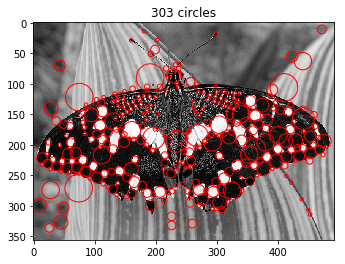

<--------------------Blob Detection-------------------->
Implementation: downsample Time:: 152590900
<------------------------------------------------------>


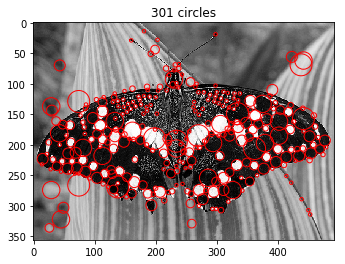

In [117]:
k = 1.2599
num_sigma = 10
min_sigma = 2
threshold = 0.02
nms_size = 10

butterfly = cv2.imread("butterfly.jpg", 0).astype("float") / 255    
blob_detection(butterfly, "butterfly", num_sigma, method="normal", threshold=threshold, nms_size=nms_size)
blob_detection(butterfly, "butterfly", num_sigma, method="downsample", threshold=threshold, nms_size=nms_size)

<--------------------Blob Detection-------------------->
Implementation: normal Time:: 468144200
<------------------------------------------------------>


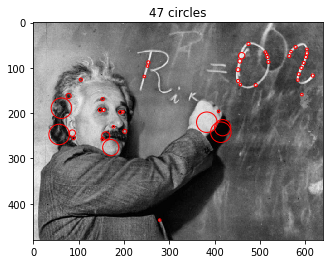

<--------------------Blob Detection-------------------->
Implementation: downsample Time:: 241393800
<------------------------------------------------------>


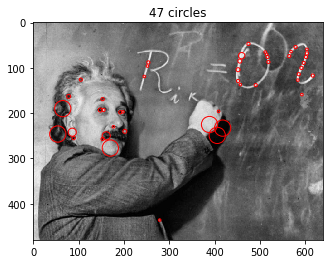

In [118]:
einstein = cv2.imread("einstein.jpg", 0).astype("float") / 255    
blob_detection(einstein, "einstein", num_sigma, method="normal", threshold=0.05, nms_size=nms_size)
blob_detection(einstein, "einstein", num_sigma, method="downsample", threshold=0.05, nms_size=nms_size)

<--------------------Blob Detection-------------------->
Implementation: normal Time:: 485125000
<------------------------------------------------------>


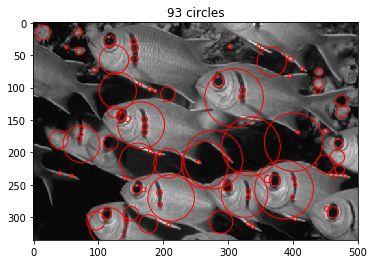

<--------------------Blob Detection-------------------->
Implementation: downsample Time:: 159828400
<------------------------------------------------------>


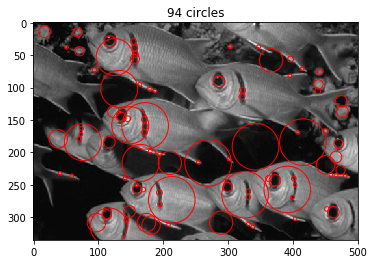

In [119]:
fishes = cv2.imread("fishes.jpg", 0).astype("float") / 255    
blob_detection(fishes, "fishes", num_sigma=13, method="normal", threshold=threshold, nms_size=nms_size)
blob_detection(fishes, "fishes", num_sigma=13, method="downsample", threshold=threshold, nms_size=nms_size)

<--------------------Blob Detection-------------------->
Implementation: normal Time:: 172541200
<------------------------------------------------------>


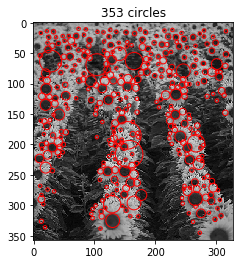

<--------------------Blob Detection-------------------->
Implementation: downsample Time:: 81861500
<------------------------------------------------------>


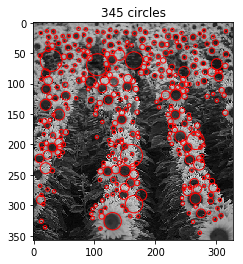

In [120]:
sunflowers = cv2.imread("sunflowers.jpg", 0).astype("float") / 255    
blob_detection(sunflowers, "sunflowers", num_sigma, method="normal", threshold=threshold, nms_size=nms_size)
blob_detection(sunflowers, "sunflowers", num_sigma, method="downsample", threshold=threshold, nms_size=nms_size)

<--------------------Blob Detection-------------------->
Implementation: normal Time:: 351643700
<------------------------------------------------------>


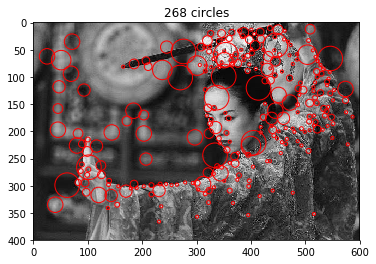

<--------------------Blob Detection-------------------->
Implementation: downsample Time:: 184540000
<------------------------------------------------------>


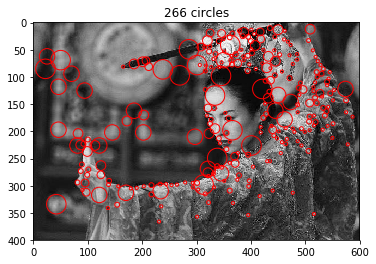

In [121]:
beauty = cv2.imread("beauty.jpg", 0).astype("float") / 255    
blob_detection(beauty, "beauty", num_sigma, method="normal", threshold=threshold, nms_size=nms_size)
blob_detection(beauty, "beauty", num_sigma, method="downsample", threshold=threshold, nms_size=nms_size)

<--------------------Blob Detection-------------------->
Implementation: normal Time:: 308717600
<------------------------------------------------------>


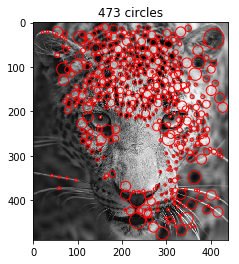

<--------------------Blob Detection-------------------->
Implementation: downsample Time:: 145568700
<------------------------------------------------------>


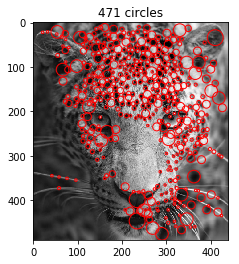

In [122]:
leopard = cv2.imread("leopard.jpg", 0).astype("float") / 255    
blob_detection(leopard, "leopard", num_sigma=10, method="normal", threshold=threshold, nms_size=nms_size)
blob_detection(leopard, "leopard", num_sigma=10, method="downsample", threshold=threshold, nms_size=nms_size)

<--------------------Blob Detection-------------------->
Implementation: normal Time:: 616310000
<------------------------------------------------------>


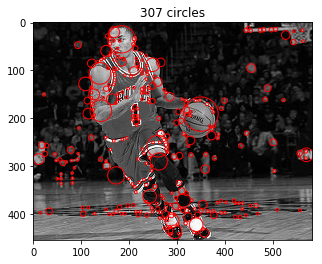

<--------------------Blob Detection-------------------->
Implementation: downsample Time:: 233229800
<------------------------------------------------------>


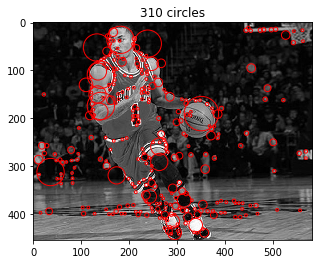

In [123]:
rose = cv2.imread("rose.jpg", 0).astype("float") / 255    
blob_detection(rose, "rose", num_sigma=12, method="normal", threshold=threshold, nms_size=nms_size)
blob_detection(rose, "rose", num_sigma=12, method="downsample", threshold=threshold, nms_size=nms_size)

<--------------------Blob Detection-------------------->
Implementation: normal Time:: 465413200
<------------------------------------------------------>


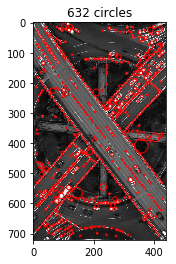

<--------------------Blob Detection-------------------->
Implementation: downsample Time:: 214804900
<------------------------------------------------------>


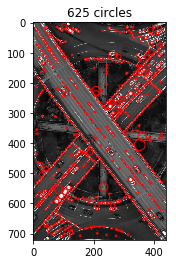

In [124]:
bridge = cv2.imread("bridge.jpg", 0).astype("float") / 255    
blob_detection(bridge, "bridge", num_sigma, method="normal", threshold=threshold, nms_size=nms_size)
blob_detection(bridge, "bridge", num_sigma, method="downsample", threshold=threshold, nms_size=nms_size)